In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import yfinance as yf # type: ignore
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor # type: ignore
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error ,mean_squared_error # type: ignore
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Baixando os preços históricos da VALE3:
df_Vale = yf.download(tickers='VALE3.SA', start='2022-01-01', end='2025-08-01', multi_level_index=False)
df_Vale = df_Vale[['Close', 'Open', 'Volume']]
df_Vale.reset_index(inplace=True)
df_Vale['Date'] = pd.to_datetime(df_Vale['Date'])
df_Vale.set_index('Date', inplace=True)
df_Vale.rename(columns={
    'Close': 'Close_VALE3',
    'Open': 'Open_VALE3',
    'Volume': 'Volume_VALE3'
}, inplace=True)

# Baixando os preços históricos do minério de ferro:
df_ferro = pd.read_csv("Dados Históricos - Minério de ferro refinado 62% Fe CFR Futuros.csv")
df_ferro.reset_index(inplace=True)
df_ferro['Data'] = pd.to_datetime(df_ferro['Data'], dayfirst=True)
df_ferro.set_index('Data', inplace=True)
df_ferro = df_ferro[['Último','Abertura', 'Var%']]
# Invertendo a ordem das datas:
df_ferro = df_ferro.sort_index(ascending=True)
df_ferro.rename(columns={
    'Último': 'Close_Ferro',
    'Abertura': 'Open_Ferro',
    'Var%': 'Variacao_ferro'
}, inplace=True) 

# Agora vamos unir os dataframes:

df = pd.merge(df_Vale, df_ferro, left_index=True, right_index=True, suffixes=('_VALE3', '_Ferro'))

# Variação percentual do preço de fechamento da VALE3:
df['Variação_VALE3'] = df_Vale['Close_VALE3'].pct_change() * 100
# Trocando nan por 0%:
df['Variação_VALE3'].fillna(0, inplace=True)

# Vamos transformar as colunas Close_Minerio, Open_Minerio e Variação_Minerio em float:
df['Close_Ferro'] = df['Close_Ferro'].str.replace(',', '.', regex=False).astype(float)
df['Open_Ferro'] = df['Open_Ferro'].str.replace(',', '.', regex=False).astype(float)
df['Variacao_ferro'] = df['Variacao_ferro'].str.replace('%', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Tratamento para transforma o index em datetime após o merge:
df.reset_index(inplace=True)
df['index'] = pd.to_datetime(df['index'], dayfirst=True)
df.rename(columns={'index': 'Data'}, inplace=True)
df.set_index('Data', inplace=True)

[*********************100%***********************]  1 of 1 completed


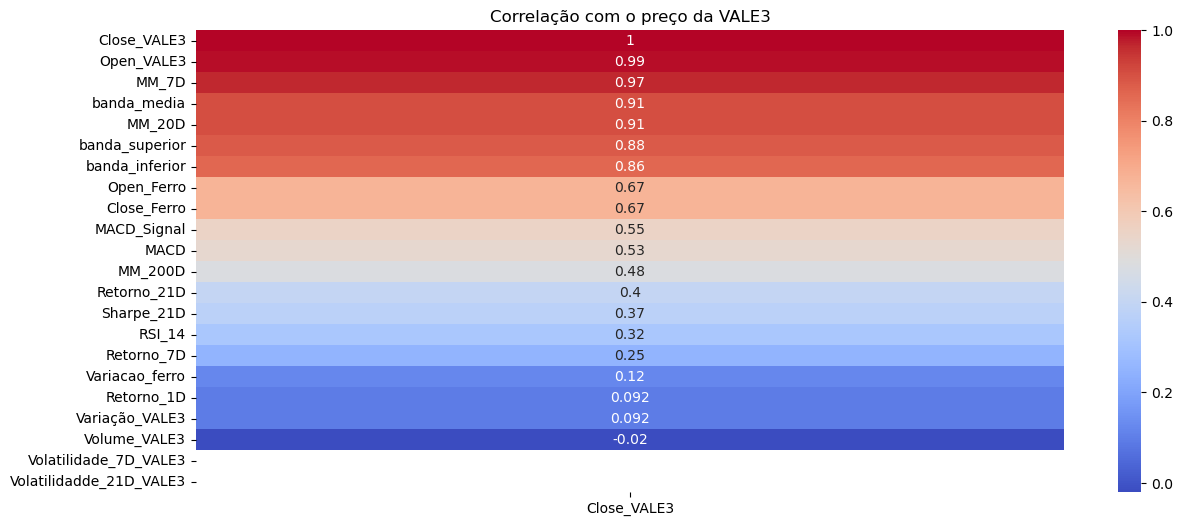

In [3]:
janelas = [7,20,200]

for janela in janelas:
    df[f'MM_{janela}D'] = df['Close_VALE3'].rolling(window=janela, min_periods=1).mean()

retornos = [1,7,21]

for retorno in retornos:
    df[f'Retorno_{retorno}D'] = df['Close_VALE3'].pct_change(retorno) * 100
    df[f'Retorno_{retorno}D'].fillna(0, inplace=True)

def calcular_RSI(series, windows=14):
    delta = series.diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_again = gain.rolling(window=windows).mean()
    avg_loss = loss.rolling(window=windows).mean()

    rs = avg_again / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df['RSI_14'] = calcular_RSI(df['Close_VALE3'], windows=14)
df['RSI_14'].fillna(df['RSI_14'].mean(), inplace=True)


MME_12 = df['Close_VALE3'].ewm(span=12, adjust=False).mean()
MME_26 = df['Close_VALE3'].ewm(span=26, adjust=False).mean()

df['MACD'] = MME_12 - MME_26

df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# primeiro pegamos as medias móveis de 20 dias:
medias_20D = df['MM_20D']
# E o desvio padrão de 20 dias também:
desvio_20D = df['Close_VALE3'].rolling(window=20, min_periods=1).std()

# Assim podemos calcular as bandas:
df['banda_media'] = medias_20D
df['banda_superior'] = medias_20D + (2 * desvio_20D)
df['banda_inferior'] = medias_20D - (2 * desvio_20D)

# Vamos completar os valores NaN com a média dos dados para cada coluna:
df['banda_inferior'].fillna(df['banda_inferior'].mean(), inplace=True)
df['banda_superior'].fillna(df['banda_superior'].mean(), inplace=True)

def Rolling_Sharpe_Ratio(returns, window=21, risk_free_rate=0.0, trading_days=252):
    # Converter taxa livre de risco para diária:
    rf_daily = (1 + risk_free_rate)**(1/trading_days) - 1

    # Calcular retornos excedentes:
    excess_return = returns - rf_daily

    # Média móvel dos retornos excedentes:
    mean_returns = excess_return.rolling(window).mean()

    # Desvio padrão móvel dos retornos excedentes:
    std_returns = excess_return.rolling(window).std()

    # Sharpe Ratio anualizado:
    sharpe_ratio = mean_returns / std_returns * np.sqrt(trading_days)

    return sharpe_ratio

# Calculando o sharpe ratio de 21 dias( 21 dias = 1 mês de trading):
df['Sharpe_21D'] = Rolling_Sharpe_Ratio(
    returns=df['Retorno_1D'],
    window=21,
    risk_free_rate= 0.15, # 15% ao ano (SELIC atual)
    trading_days=252
)

# Tratando valores NaN do sharpe de 21 dias:
df['Sharpe_21D'].fillna(0, inplace=True)
df['Sharpe_21D'].isnull().sum()

df['Volatilidade_7D_VALE3'] = np.std(df['Retorno_7D'])
df['Volatilidadde_21D_VALE3'] = np.std(df['Retorno_21D'])
df['Volatilidade_7D_VALE3'].fillna(0, inplace=True)
df['Volatilidadde_21D_VALE3'].fillna(0, inplace=True)

# Variáveis que precisam ser normalizadas:
cols_to_scale = ['Close_Ferro', 'Volume_VALE3', 'Volatilidade_7D_VALE3', 'MACD', 'Volatilidadde_21D_VALE3']

scaler = StandardScaler()

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

plt.figure(figsize=(14,6))

corr_matriz = df.corr()
sns.heatmap(corr_matriz[['Close_VALE3']].sort_values(by='Close_VALE3', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title('Correlação com o preço da VALE3')
plt.show()

features_selecionadas = df[['Close_Ferro', 'MM_200D', 'banda_superior', 'banda_inferior', 'MACD', 
                           'RSI_14', 'Retorno_21D', 'Sharpe_21D', 'Volatilidade_7D_VALE3', 'Volume_VALE3', 'Variacao_ferro']]

# preço de fechamento de 7 dias no futuro:
df['Target_7D'] = df['Close_VALE3'].shift(-7)

df.dropna(subset=['Target_7D'], inplace=True) # Eliminação dos valores NaN

# Deslocar features em 1 dia (usar dados de ontem para prever futuro):
features = [
    'Close_Ferro', 'MM_200D', 'banda_superior', 'banda_inferior', 'MACD', 
    'RSI_14', 'Retorno_21D', 'Sharpe_21D', 'Volatilidade_7D_VALE3', 
    'Volume_VALE3', 'Variacao_ferro'
]

df[features] = df[features].shift(1)
df.dropna(inplace=True)

train = df.loc['2022-01-04':'2023-12-31']
val = df.loc['2024-01-01':'2024-06-30']
test = df.loc['2024-07-01':'2025-07-22']

X_train, y_train = train.drop(columns=['Target_7D']), train['Target_7D']
X_val, y_val = val.drop(columns=['Target_7D']), val['Target_7D']
X_test, y_test = test.drop(columns=['Target_7D']), test['Target_7D']

In [4]:
df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Ferro,Open_Ferro,Variacao_ferro,Variação_VALE3,MM_7D,MM_20D,MM_200D,...,RSI_14,MACD,MACD_Signal,banda_media,banda_superior,banda_inferior,Sharpe_21D,Volatilidade_7D_VALE3,Volatilidadde_21D_VALE3,Target_7D
Data,,,,,,,,,,,,,,,,,,,,,
2022-01-04,55.149845,56.172994,-0.623531,0.388809,120.91,7.02,-1.179493,55.478971,55.478971,55.808098,...,49.600138,0.023054,-0.010502,55.478971,61.117827,53.901633,0.000000,-1.776357e-15,-1.776357e-15,60.244125
2022-01-05,55.672150,55.357338,-0.652010,0.420539,124.14,0.42,0.947064,55.543364,55.543364,55.478971,...,49.600138,-0.022450,-0.018679,55.543364,56.409881,54.548062,0.000000,-1.776357e-15,-1.776357e-15,60.594707
2022-01-06,56.795467,56.266007,-0.361546,0.621496,125.94,2.67,2.017737,55.856390,55.856390,55.543364,...,49.600138,-0.021477,-0.007006,55.856390,56.238385,54.848344,0.000000,-1.776357e-15,-1.776357e-15,61.753803
2022-01-07,60.101032,57.525275,-0.361162,0.733484,126.21,1.45,5.820121,56.705318,56.705318,55.856390,...,49.600138,0.057447,0.069252,56.705318,57.231089,54.481691,0.000000,-1.776357e-15,-1.776357e-15,63.113232
2022-01-10,59.385540,59.020639,0.629726,0.750282,124.48,0.21,-1.190482,57.152022,57.152022,56.705318,...,49.600138,0.347398,0.170419,57.152022,60.684130,52.726507,0.000000,-1.776357e-15,-1.776357e-15,62.039993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-16,52.555805,52.265972,-0.136559,-1.098147,97.06,-0.27,0.908930,52.938102,51.363636,52.802584,...,65.304254,0.504243,0.364698,51.363636,55.062112,47.610093,0.892204,-1.776357e-15,-1.776357e-15,53.811733
2025-07-17,52.459194,52.555806,-0.033851,-1.063306,97.18,0.58,-0.183826,52.899458,51.503238,52.795799,...,67.132877,0.477957,0.389257,51.503238,55.118489,47.608784,1.725637,-1.776357e-15,-1.776357e-15,53.290039
2025-07-18,52.710381,52.217668,-0.495947,-1.055840,97.22,0.12,0.478822,52.971226,51.663610,52.788532,...,61.477051,0.445501,0.405931,51.663610,55.199675,47.806801,0.482741,-1.776357e-15,-1.776357e-15,52.961563


In [5]:
df.columns

Index(['Close_VALE3', 'Open_VALE3', 'Volume_VALE3', 'Close_Ferro',
       'Open_Ferro', 'Variacao_ferro', 'Variação_VALE3', 'MM_7D', 'MM_20D',
       'MM_200D', 'Retorno_1D', 'Retorno_7D', 'Retorno_21D', 'RSI_14', 'MACD',
       'MACD_Signal', 'banda_media', 'banda_superior', 'banda_inferior',
       'Sharpe_21D', 'Volatilidade_7D_VALE3', 'Volatilidadde_21D_VALE3',
       'Target_7D'],
      dtype='object')

* Modelo SARIMA:

In [6]:
# SARIMA com variável exógena (preço do minério de ferro):
modelo_sarima = SARIMAX(
    endog = y_train,
    exog = X_train[['Close_Ferro', 'MM_20D', 'Close_VALE3', 'Open_VALE3', 'MM_200D', 'MM_7D']],
    order = (1, 1, 2),
    seasonal_order = (1, 1, 1, 30),
    enforce_stationarity = False,
    enforce_invertibility = False
)

# Treinar o modelo:
results_sarima = modelo_sarima.fit(disp=False)

# Previsão na validação (com dados exógenos):
sarima_val_pred = results_sarima.get_forecast(
    steps=len(y_val),
    exog = X_val[['Close_Ferro', 'MM_20D', 'Close_VALE3', 'Open_VALE3', 'MM_200D', 'MM_7D']]
).predicted_mean

# Avaliação
sarima_mae = mean_absolute_error(y_val, sarima_val_pred)
print(f"SARIMA MAE: {sarima_mae:.4f}")
sarima_mape = mean_absolute_percentage_error(y_val, sarima_val_pred)
print(f"SARIMA MAPE: {sarima_mape:.4f}")

SARIMA MAE: 3.0912
SARIMA MAPE: 0.0556


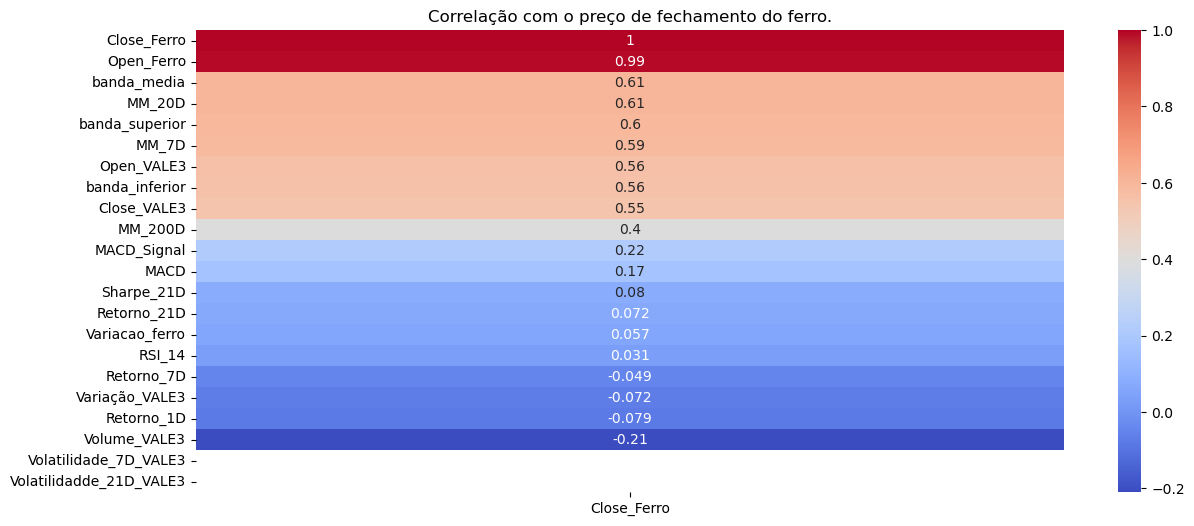

In [7]:
plt.figure(figsize=(14,6))

corr_matriz2 = X_train.corr()
sns.heatmap(corr_matriz2[['Close_Ferro']].sort_values(by='Close_Ferro', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title('Correlação com o preço de fechamento do ferro.')
plt.show()

* Modelo XGBoost:

[0]	validation_0-rmse:6.64103
[50]	validation_0-rmse:5.37978
[100]	validation_0-rmse:4.40305
[150]	validation_0-rmse:3.65116
[200]	validation_0-rmse:3.07181
[250]	validation_0-rmse:2.62626
[300]	validation_0-rmse:2.28667
[350]	validation_0-rmse:2.01913
[400]	validation_0-rmse:1.80721
[450]	validation_0-rmse:1.64676
[500]	validation_0-rmse:1.51868
[550]	validation_0-rmse:1.41212
[600]	validation_0-rmse:1.32378
[650]	validation_0-rmse:1.25245
[700]	validation_0-rmse:1.19030
[750]	validation_0-rmse:1.13783
[800]	validation_0-rmse:1.09003
[850]	validation_0-rmse:1.04530
[900]	validation_0-rmse:1.00769
[950]	validation_0-rmse:0.97289
[1000]	validation_0-rmse:0.93800
[1050]	validation_0-rmse:0.90780
[1100]	validation_0-rmse:0.87908
[1150]	validation_0-rmse:0.85142
[1200]	validation_0-rmse:0.82584
[1250]	validation_0-rmse:0.80179
[1300]	validation_0-rmse:0.78006
[1350]	validation_0-rmse:0.75859
[1400]	validation_0-rmse:0.73770
[1450]	validation_0-rmse:0.71682
[1499]	validation_0-rmse:0.69810


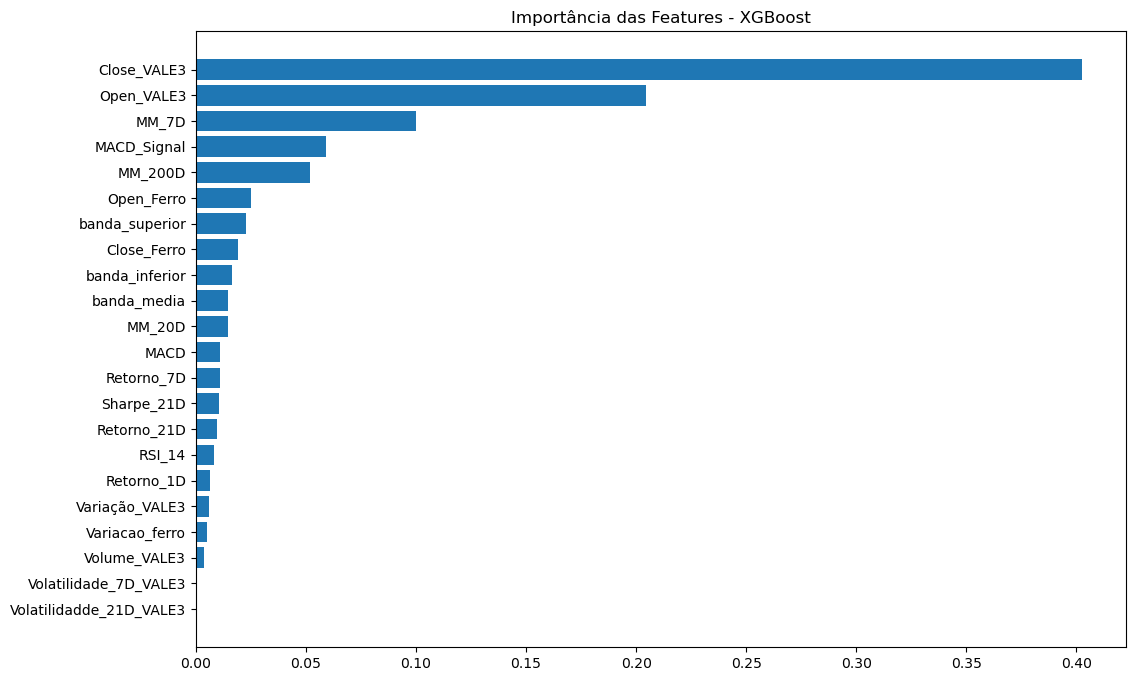

In [8]:
# Modelo XGBoost com early stopping:
modelo_xgb = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.005,  
    max_depth=4,         
    gamma=0.2,   
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42
)

# Treinamento com validação:
modelo_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)],
    verbose=50
)

# Previsão:
xgb_val_pred = modelo_xgb.predict(X_val)

# Avaliação:
xgb_mae = mean_absolute_error(y_val, xgb_val_pred)
print(f"XGBoost MAE: {xgb_mae:.4f}")
xgb_mape = mean_absolute_percentage_error(y_val, xgb_val_pred)
print(f"XGBoost MAPE: {xgb_mape:.4f}")

# Importância das features
plt.figure(figsize=(12, 8))
sorted_idx = modelo_xgb.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], modelo_xgb.feature_importances_[sorted_idx])
plt.title("Importância das Features - XGBoost")
plt.show()

* Modelo LSTM:

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 58.0087 - val_loss: 49.9816
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 52.8287 - val_loss: 44.5921
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 46.4075 - val_loss: 37.9135
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 39.7991 - val_loss: 30.7224
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 32.4130 - val_loss: 22.5263
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 23.7405 - val_loss: 13.5555
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 14.3232 - val_loss: 3.8310
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.6441 - val_loss: 3.1285
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 5.5364 - val_loss: 3.6943
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 5.5468 - val_loss: 2.0928
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.1666 - val_loss: 1.6603
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━

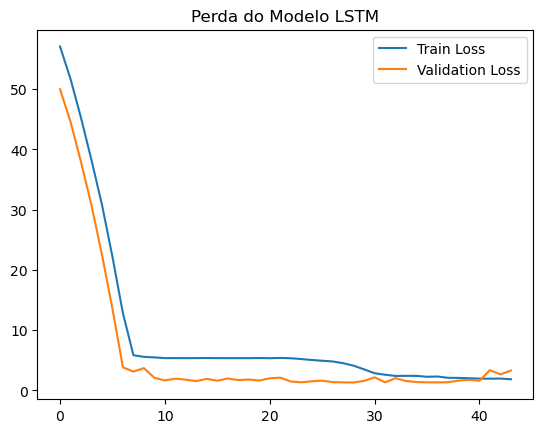

In [9]:
# Normalização completa:
scaller_all = StandardScaler()
X_train_scaled = scaller_all.fit_transform(X_train)
X_val_scaled = scaller_all.transform(X_val)

# Parâmetros da sequência:
window_size = 60
n_features = X_train_scaled.shape[1]

# Função para criar sequências:
def criar_sequencia(data, targets, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(targets[i])
    return np.array(X), np.array(y)

# Preparar dados sequenciais:
X_train_seq, y_train_seq =criar_sequencia(X_train_scaled, y_train.values, window_size)
X_val_seq, y_val_seq =criar_sequencia(X_val_scaled, y_val.values, window_size)

# Construir modelo LSTM
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, n_features)),
    LSTM(64, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compilar
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_absolute_error'
)

# Callback para early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Treinar
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stop],
    verbose=1
)

# Previsão
lstm_val_pred = lstm_model.predict(X_val_seq).flatten()

# Avaliação
lstm_mae = mean_absolute_error(y_val[window_size:], lstm_val_pred)
print(f"LSTM MAE: {lstm_mae:.4f}")
lstm_mape = mean_absolute_percentage_error(y_val[window_size:], lstm_val_pred)
print(f"LSTM MAPE: {lstm_mape:.4f}")

# Plot de perda
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Perda do Modelo LSTM')
plt.show()


* Ensemble:

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

MAE do Ensemble: 2.3854
MAPE do Ensemble: 4.3463%



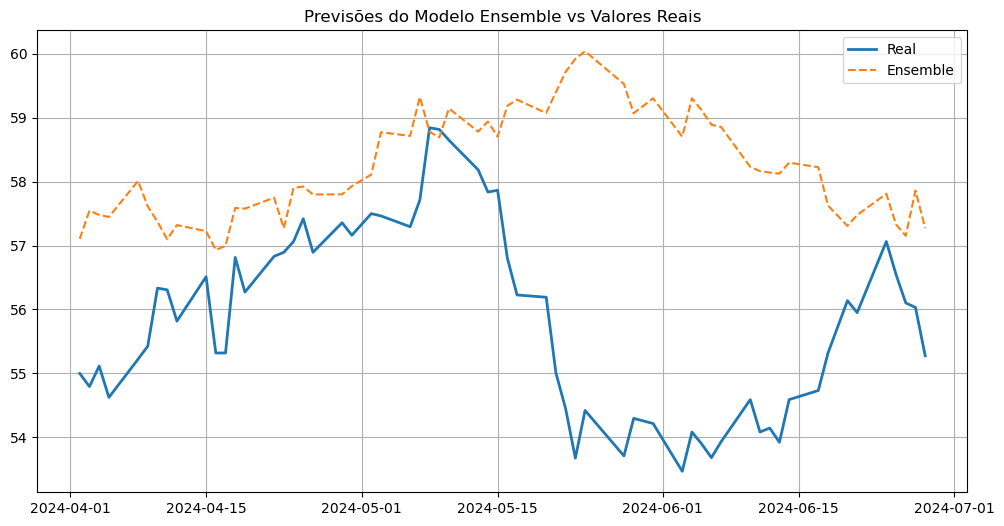

In [ ]:
from sklearn.linear_model import LinearRegression

# 1 Variáveis exógenas usadas no SARIMA:
exog_vars = ['Close_Ferro', 'MM_20D', 'Close_VALE3', 'Open_VALE3', 'MM_200D', 'MM_7D']

# 2. Preparar as previsões individuais (treino/validação):
train_pred_sarima = results_sarima.get_forecast(steps=len(X_train), exog=X_train[exog_vars]).predicted_mean.values
train_pred_xgb = modelo_xgb.predict(X_train)
train_pred_lstm = lstm_model.predict(X_train_seq).flatten()

# 3. Calcular quantas amostras a LSTM "perdeu" devido à janela:
window_size = 60 
samples_to_cut = len(X_train) - len(train_pred_lstm)  # 482 - 422 = 60

# 4. Alinhar previsões de treino:
aligned_train_pred_sarima = train_pred_sarima[samples_to_cut:]
aligned_train_pred_xgb = train_pred_xgb[samples_to_cut:]
aligned_y_train = y_train.iloc[samples_to_cut:]

# 5. Treinar meta-modelo:
meta_features = np.column_stack([
    aligned_train_pred_sarima,
    aligned_train_pred_xgb,
    train_pred_lstm
])
meta_modelo = LinearRegression().fit(meta_features, aligned_y_train)

# 6. Gerar previsões de validação:

# SARIMA
val_pred_sarima = results_sarima.get_forecast(
    steps=len(X_val),
    exog=X_val[exog_vars]
).predicted_mean.values

# XGBoost
val_pred_xgb = modelo_xgb.predict(X_val)

# LSTM
val_pred_lstm = lstm_model.predict(X_val_seq).flatten()

# 7. Alinhar previsões de validação
val_samples_to_cut = len(X_val) - len(val_pred_lstm)
aligned_val_pred_sarima = val_pred_sarima[val_samples_to_cut:]
aligned_val_pred_xgb = val_pred_xgb[val_samples_to_cut:]
aligned_y_val = y_val.iloc[val_samples_to_cut:]

# 8. Fazer previsão do ensemble:
val_preds = np.column_stack([
    aligned_val_pred_sarima,
    aligned_val_pred_xgb,
    val_pred_lstm
])
ensemble_pred = meta_modelo.predict(val_preds)

# 9. Avaliação final:
mae = mean_absolute_error(aligned_y_val, ensemble_pred)
mape = mean_absolute_percentage_error(aligned_y_val, ensemble_pred)

print("\n" + "="*50)
print(f"MAE do Ensemble: {mae:.4f}")
print(f"MAPE do Ensemble: {mape:.4%}")
print("="*50 + "\n")

# 10. Visualização:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(aligned_y_val.index, aligned_y_val, label='Real', linewidth=2)
plt.plot(aligned_y_val.index, ensemble_pred, label='Ensemble', linestyle='--')
plt.title('Previsões do Modelo Ensemble vs Valores Reais')
plt.legend()
plt.grid()
plt.show()
